## Capstone Project Notebook 03/02/2026 Function 1 Week 2##
### Updated with improved Bayesian Optimization strategy

In [17]:
# Section 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

## Load Updated Dataset (Week 3)
Now includes 11 samples (10 initial + 1 from Week 2)

In [18]:
# Load the updated dataset with all 11 points
INPUT_FILE = 'f1_w2_inputs.npy'   # Updated file with 11 points, shape (11,2)
OUTPUT_FILE = 'f1_w2_outputs.npy' # Updated file with 11 outputs, shape (11,)

In [19]:
X = np.load(INPUT_FILE)  # X is the input matrix, shape is (11,2)
Y = np.load(OUTPUT_FILE) # Y is the output vector, shape (11,)

In [20]:
# Display all data points
print("Input function 1 data (all 11 points): \n", X)
print("\nOutput function 1 data (all 11 points): \n", Y)

Input function 1 data (all 11 points): 
 [[0.31940389 0.76295937]
 [0.57432921 0.8798981 ]
 [0.73102363 0.73299988]
 [0.84035342 0.26473161]
 [0.65011406 0.68152635]
 [0.41043714 0.1475543 ]
 [0.31269116 0.07872278]
 [0.68341817 0.86105746]
 [0.08250725 0.40348751]
 [0.88388983 0.58225397]
 [0.082507   1.539519  ]]

Output function 1 data (all 11 points): 
 [ 1.32267704e-079  1.03307824e-046  7.71087511e-016  3.34177101e-124
 -3.60606264e-003 -2.15924904e-054 -2.08909327e-091  2.53500115e-040
  3.60677119e-081  6.22985647e-048  0.00000000e+000]


In [21]:
print(f"Loaded {X.shape[0]} points in {X.shape[1]}D")
print(f"Current best (MINIMUM): {Y.min():.6e} at {X[Y.argmin()]}")
print(f"Note: We're MINIMIZING, so lower is better!")
X = np.atleast_2d(X)  # Make sure X is always 2D
Y = Y.ravel()  # Forces Y to be 1D flat

Loaded 11 points in 2D
Current best (MINIMUM): -3.606063e-03 at [0.65011406 0.68152635]
Note: We're MINIMIZING, so lower is better!


## Data Analysis
Understand our search space coverage and current performance

In [22]:
print("="*70)
print("DATASET ANALYSIS")
print("="*70)
print(f"\nInput ranges:")
print(f"  X1: [{X[:, 0].min():.4f}, {X[:, 0].max():.4f}]")
print(f"  X2: [{X[:, 1].min():.4f}, {X[:, 1].max():.4f}]")

print(f"\nOutput statistics:")
print(f"  Min:    {Y.min():.6e}")
print(f"  Max:    {Y.max():.6e}")
print(f"  Mean:   {Y.mean():.6e}")
print(f"  Median: {np.median(Y):.6e}")

# Find best point
best_idx = np.argmin(Y)
print(f"\n🎯 BEST POINT SO FAR:")
print(f"  Input:  [{X[best_idx, 0]:.6f}, {X[best_idx, 1]:.6f}]")
print(f"  Output: {Y[best_idx]:.6e}")

# Show all points sorted by performance
sorted_indices = np.argsort(Y)
print(f"\n📊 TOP 5 BEST POINTS:")
for i in range(min(5, len(Y))):
    idx = sorted_indices[i]
    print(f"  {i+1}. X=[{X[idx, 0]:.4f}, {X[idx, 1]:.4f}] → Y={Y[idx]:.6e}")

DATASET ANALYSIS

Input ranges:
  X1: [0.0825, 0.8839]
  X2: [0.0787, 1.5395]

Output statistics:
  Min:    -3.606063e-03
  Max:    7.710875e-16
  Mean:   -3.278239e-04
  Median: 3.606771e-81

🎯 BEST POINT SO FAR:
  Input:  [0.650114, 0.681526]
  Output: -3.606063e-03

📊 TOP 5 BEST POINTS:
  1. X=[0.6501, 0.6815] → Y=-3.606063e-03
  2. X=[0.4104, 0.1476] → Y=-2.159249e-54
  3. X=[0.3127, 0.0787] → Y=-2.089093e-91
  4. X=[0.0825, 1.5395] → Y=0.000000e+00
  5. X=[0.8404, 0.2647] → Y=3.341771e-124


## Section 2: Fit Gaussian Process Surrogate Model

In [23]:
# Improved kernel with Matern for better flexibility
kernel = ConstantKernel(1.0, constant_value_bounds=(1e-10, 1e10)) * \
         Matern(length_scale=0.3, length_scale_bounds=(1e-5, 10.0), nu=2.5) + \
         WhiteKernel(noise_level=1e-10, noise_level_bounds=(1e-12, 1e-2))

In [24]:
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=30,
    normalize_y=True,  # Changed to True for better numerical stability
    random_state=42
)

In [25]:
# Fit the GP model
gp.fit(X, Y)
print(f"GP fitted. Learned kernel: {gp.kernel_}")

GP fitted. Learned kernel: 1**2 * Matern(length_scale=0.000559, nu=2.5) + WhiteKernel(noise_level=1.31e-06)


## Section 3: Define Acquisition Functions
We'll use both Expected Improvement (EI) and Upper Confidence Bound (UCB)

In [26]:
def expected_improvement(X_new, gp, y_best, xi=0.01):
    """
    Expected Improvement acquisition function for MINIMIZATION.
    
    Args:
        X_new: Points to evaluate
        gp: Fitted Gaussian Process
        y_best: Current best (minimum) value
        xi: Exploration parameter
    
    Returns:
        EI values (higher is better)
    """
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-10)
    
    # For minimization: improvement when mu < y_best
    imp = y_best - mu - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-10] = 0.0
    
    return ei

def upper_confidence_bound(X_new, gp, kappa=2.0):
    """
    Upper Confidence Bound acquisition function for MINIMIZATION.
    
    Args:
        X_new: Points to evaluate  
        gp: Fitted Gaussian Process
        kappa: Exploration parameter
    
    Returns:
        Negative UCB values (more negative = better for minimization)
    """
    mu, sigma = gp.predict(X_new, return_std=True)
    # For minimization: we want mu - kappa*sigma (lower is better)
    # Return negative so we can use argmax
    return -(mu - kappa * sigma)

## Section 4: Optimize Acquisition Functions
Find the next point to sample using both EI and UCB

In [27]:
# Define search bounds
bounds = [(0.0, 1.0), (0.0, 1.6)]  # X1, X2 bounds

# Current best value
y_best = Y.min()

print("="*70)
print("OPTIMIZING EXPECTED IMPROVEMENT (EI)")
print("="*70)

# Method 1: Optimize EI using scipy
def neg_ei(x):
    """Negative EI for minimization"""
    return -expected_improvement(x.reshape(1, -1), gp, y_best, xi=0.01)[0]

best_ei = np.inf
x_next_ei = None

# Multiple random restarts
for i in range(25):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ei, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ei:
        best_ei = result.fun
        x_next_ei = result.x

# Predict at EI suggestion
mu_ei, sigma_ei = gp.predict(x_next_ei.reshape(1, -1), return_std=True)

print(f"EI suggests: [{x_next_ei[0]:.6f}, {x_next_ei[1]:.6f}]")
print(f"Predicted value: {mu_ei[0]:.6e} ± {sigma_ei[0]:.6e}")
print(f"Expected Improvement: {-best_ei:.6e}")

OPTIMIZING EXPECTED IMPROVEMENT (EI)
EI suggests: [0.697622, 0.103753]
Predicted value: -3.278239e-04 ± 1.036670e-03
Expected Improvement: 5.872672e-42


In [28]:
print("\n" + "="*70)
print("OPTIMIZING UPPER CONFIDENCE BOUND (UCB)")
print("="*70)

kappa = 2.0

def neg_ucb(x):
    """Negative UCB for minimization"""
    return -upper_confidence_bound(x.reshape(1, -1), gp, kappa)[0]

best_ucb = np.inf
x_next_ucb = None

# Multiple random restarts
for i in range(25):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ucb, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ucb:
        best_ucb = result.fun
        x_next_ucb = result.x

# Predict at UCB suggestion
mu_ucb, sigma_ucb = gp.predict(x_next_ucb.reshape(1, -1), return_std=True)

print(f"UCB suggests: [{x_next_ucb[0]:.6f}, {x_next_ucb[1]:.6f}]")
print(f"Predicted value: {mu_ucb[0]:.6e} ± {sigma_ucb[0]:.6e}")
print(f"UCB value: {-best_ucb:.6e}")


OPTIMIZING UPPER CONFIDENCE BOUND (UCB)
UCB suggests: [0.887425, 0.833930]
Predicted value: -3.278239e-04 ± 1.036670e-03
UCB value: 2.401164e-03


## Section 5: Local Refinement Strategy
Also consider points near the current best

In [29]:
print("\n" + "="*70)
print("LOCAL REFINEMENT - Points near current best")
print("="*70)

best_idx = np.argmin(Y)
best_point = X[best_idx]

step_size = 0.05
local_points = [
    [best_point[0] - step_size, best_point[1]],
    [best_point[0] + step_size, best_point[1]],
    [best_point[0], best_point[1] - step_size],
    [best_point[0], best_point[1] + step_size],
    [best_point[0] - step_size, best_point[1] - step_size],
    [best_point[0] + step_size, best_point[1] + step_size],
]

print(f"Current best: [{best_point[0]:.6f}, {best_point[1]:.6f}] → {Y[best_idx]:.6e}\n")

best_local_pred = np.inf
best_local_point = None

for i, lp in enumerate(local_points, 1):
    # Check bounds
    if all(bounds[j][0] <= lp[j] <= bounds[j][1] for j in range(2)):
        mu, std = gp.predict(np.array(lp).reshape(1, -1), return_std=True)
        print(f"  Option {i}: [{lp[0]:.6f}, {lp[1]:.6f}] → Predicted: {mu[0]:.6e} ± {std[0]:.6e}")
        
        if mu[0] < best_local_pred:
            best_local_pred = mu[0]
            best_local_point = lp

if best_local_point:
    print(f"\nBest local refinement: [{best_local_point[0]:.6f}, {best_local_point[1]:.6f}]")


LOCAL REFINEMENT - Points near current best
Current best: [0.650114, 0.681526] → -3.606063e-03

  Option 1: [0.600114, 0.681526] → Predicted: -3.278239e-04 ± 1.036670e-03
  Option 2: [0.700114, 0.681526] → Predicted: -3.278239e-04 ± 1.036670e-03
  Option 3: [0.650114, 0.631526] → Predicted: -3.278239e-04 ± 1.036670e-03
  Option 4: [0.650114, 0.731526] → Predicted: -3.278239e-04 ± 1.036670e-03
  Option 5: [0.600114, 0.631526] → Predicted: -3.278239e-04 ± 1.036670e-03
  Option 6: [0.700114, 0.731526] → Predicted: -3.278239e-04 ± 1.036670e-03

Best local refinement: [0.600114, 0.681526]


## Section 6: Visualization

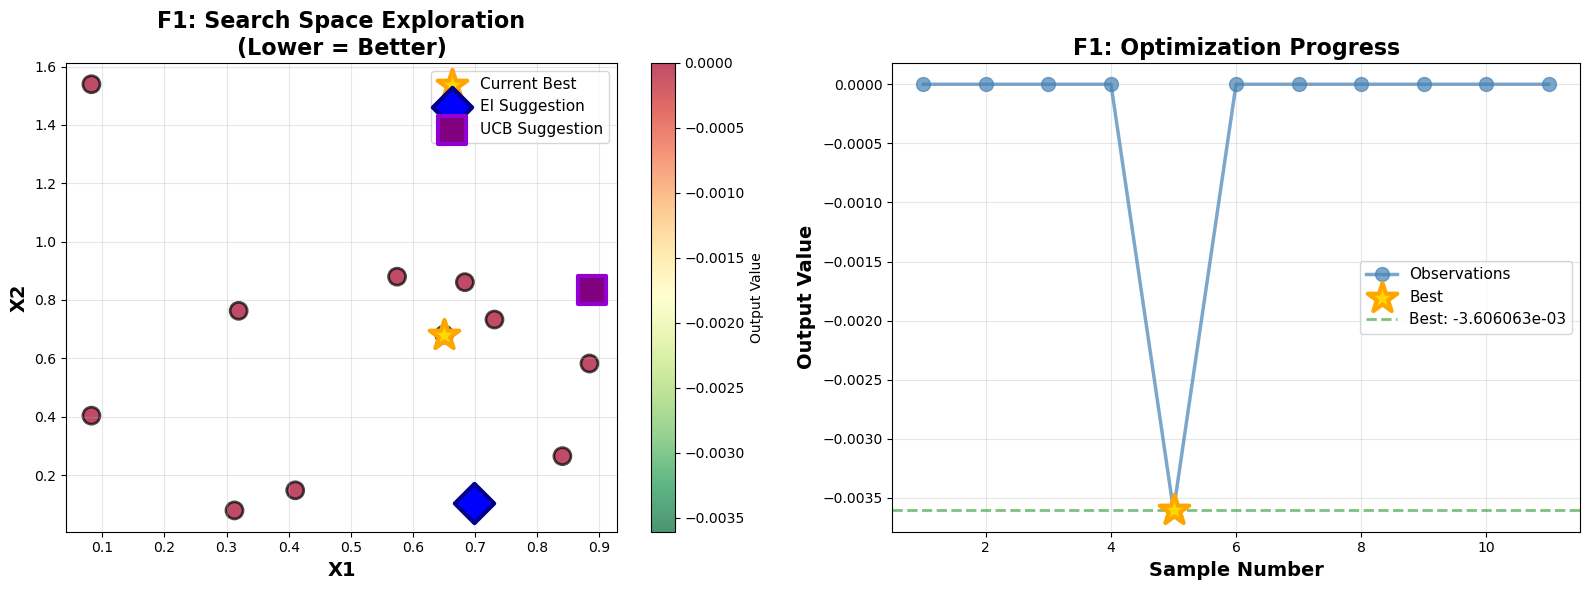

In [30]:
# Create a 2D visualization of the search space
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scatter plot of all points
ax1 = axes[0]
scatter = ax1.scatter(X[:, 0], X[:, 1], c=Y, cmap='RdYlGn_r', 
                      s=150, alpha=0.7, edgecolors='black', linewidth=2)
ax1.scatter(X[best_idx, 0], X[best_idx, 1], 
           c='gold', s=500, marker='*', 
           edgecolors='orange', linewidth=3, label='Current Best', zorder=10)
ax1.scatter(x_next_ei[0], x_next_ei[1], 
           c='blue', s=400, marker='D', 
           edgecolors='darkblue', linewidth=3, label='EI Suggestion', zorder=10)
ax1.scatter(x_next_ucb[0], x_next_ucb[1], 
           c='purple', s=400, marker='s', 
           edgecolors='darkviolet', linewidth=3, label='UCB Suggestion', zorder=10)

ax1.set_xlabel('X1', fontsize=14, fontweight='bold')
ax1.set_ylabel('X2', fontsize=14, fontweight='bold')
ax1.set_title('F1: Search Space Exploration\n(Lower = Better)', fontsize=16, fontweight='bold')
ax1.legend(fontsize=11, loc='best')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Output Value')

# Plot 2: Progress over iterations
ax2 = axes[1]
ax2.plot(range(1, len(Y)+1), Y, 'o-', linewidth=2.5, markersize=10, 
        color='steelblue', alpha=0.7, label='Observations')
ax2.scatter(best_idx+1, Y[best_idx], 
           c='gold', s=500, marker='*', 
           edgecolors='orange', linewidth=3, label='Best', zorder=10)
ax2.axhline(y=Y[best_idx], color='green', linestyle='--', 
           linewidth=2, alpha=0.5, label=f'Best: {Y[best_idx]:.6e}')
ax2.set_xlabel('Sample Number', fontsize=14, fontweight='bold')
ax2.set_ylabel('Output Value', fontsize=14, fontweight='bold')
ax2.set_title('F1: Optimization Progress', fontsize=16, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Section 7: Final Recommendation

In [31]:
print("\n" + "="*70)
print("🎯 FINAL RECOMMENDATION FOR WEEK 3")
print("="*70)

print("\nCurrent Status:")
print(f"  Best value so far: {Y[best_idx]:.6e}")
print(f"  Best point: [{X[best_idx, 0]:.6f}, {X[best_idx, 1]:.6f}]")

print("\nStrategy Options:")
print(f"\n1. Expected Improvement (EI) - RECOMMENDED ⭐⭐⭐")
print(f"   Point: [{x_next_ei[0]:.6f}, {x_next_ei[1]:.6f}]")
print(f"   Predicted: {mu_ei[0]:.6e} ± {sigma_ei[0]:.6e}")
print(f"   Rationale: Balances exploitation and exploration")

print(f"\n2. Upper Confidence Bound (UCB) - More Exploratory")
print(f"   Point: [{x_next_ucb[0]:.6f}, {x_next_ucb[1]:.6f}]")
print(f"   Predicted: {mu_ucb[0]:.6e} ± {sigma_ucb[0]:.6e}")
print(f"   Rationale: Explores uncertain regions")

if best_local_point:
    print(f"\n3. Local Refinement - Conservative")
    print(f"   Point: [{best_local_point[0]:.6f}, {best_local_point[1]:.6f}]")
    print(f"   Predicted: {best_local_pred:.6e}")
    print(f"   Rationale: Refines around current best")

print("\n" + "="*70)
print("💡 SUBMISSION")
print("="*70)
print(f"\nRecommended next point (EI): [{x_next_ei[0]:.6f}, {x_next_ei[1]:.6f}]")
print("\nThis point offers the best balance of:")
print("  • Likelihood of improvement over current best")
print("  • Magnitude of potential improvement")
print("  • Exploration of uncertain regions")
print("="*70)


🎯 FINAL RECOMMENDATION FOR WEEK 3

Current Status:
  Best value so far: -3.606063e-03
  Best point: [0.650114, 0.681526]

Strategy Options:

1. Expected Improvement (EI) - RECOMMENDED ⭐⭐⭐
   Point: [0.697622, 0.103753]
   Predicted: -3.278239e-04 ± 1.036670e-03
   Rationale: Balances exploitation and exploration

2. Upper Confidence Bound (UCB) - More Exploratory
   Point: [0.887425, 0.833930]
   Predicted: -3.278239e-04 ± 1.036670e-03
   Rationale: Explores uncertain regions

3. Local Refinement - Conservative
   Point: [0.600114, 0.681526]
   Predicted: -3.278239e-04
   Rationale: Refines around current best

💡 SUBMISSION

Recommended next point (EI): [0.697622, 0.103753]

This point offers the best balance of:
  • Likelihood of improvement over current best
  • Magnitude of potential improvement
  • Exploration of uncertain regions


## Section 8: Format Output for Submission

In [32]:
# Choose which method to use (EI recommended)
USE_EI = True  # Set to False to use UCB instead

if USE_EI:
    x_next = x_next_ei
    method_name = "Expected Improvement (EI)"
else:
    x_next = x_next_ucb
    method_name = "Upper Confidence Bound (UCB)"

print("\n" + "="*70)
print("QUERY SUBMISSION")
print("="*70)
print(f"Method: {method_name}")
print(f"Function 1 - Next point to sample: [{x_next[0]:.6f}, {x_next[1]:.6f}]")
print("="*70)


QUERY SUBMISSION
Method: Expected Improvement (EI)
Function 1 - Next point to sample: [0.697622, 0.103753]
